# Series Data Exploration

This notebook demonstrates exploring multi-stimulus data structure:
- Understanding series data format
- Inspecting stimulus timing
- Visualizing the full recording
- Identifying data patterns and issues

In [7]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pypipr

Loading real pupil series data...


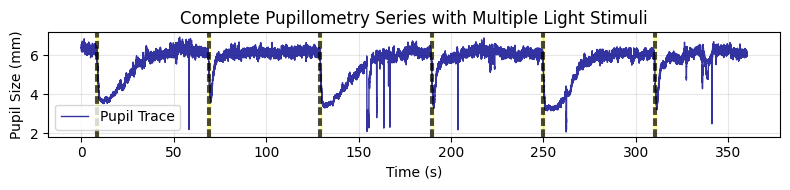

In [8]:
# Load series data
print("Loading real pupil series data...")
ps = pypipr.load_real_series()
# Plot the complete series with stimulus markers
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ps = pypipr.load_real_series()

# Plot pupil trace
ps.plot(ax=ax, label="Pupil Trace", color="darkblue", alpha=0.8, linewidth=1)

# Add light stimuli markers
ps.plot_light_stimulus(ax=ax, color="yellow", alpha=0.3, label="_Light Stimuli")

ax.set_title("Complete Pupillometry Series with Multiple Light Stimuli")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pupil Size (mm)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

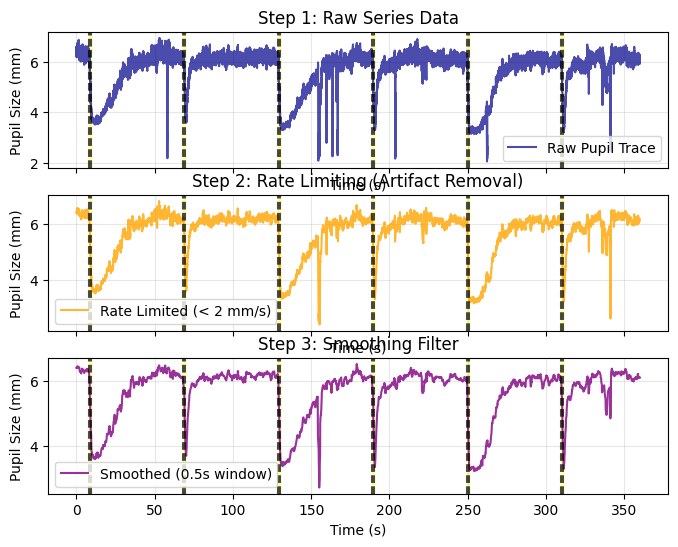

Data quality improvement:
Data points removed by rate limiting: 65779
Percentage of data retained: 7.3%
Noise reduction (std): 0.854 → 1.028 mm


In [9]:
ps = pypipr.load_real_series()
# Demonstrate preprocessing pipeline for series data
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Step 1: Original data
ps.plot(ax=ax[0], label="Raw Pupil Trace", color="darkblue", alpha=0.7)
ps.plot_light_stimulus(
    ax=ax[0], color="yellow", alpha=0.3, label="_Light Stimuli"
)
ax[0].set_title("Step 1: Raw Series Data")
ax[0].set_ylabel("Pupil Size (mm)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Step 2: Rate limiting (remove artifacts)
ps_rate_limited = ps.copy()
ps_rate_limited.limit_rate_of_change(2.0)  # Remove points with >2 mm/s change
ps_rate_limited.drop_nan()
ps_rate_limited.plot(ax=ax[1], label="Rate Limited (< 2 mm/s)", color="orange", alpha=0.8)
ps_rate_limited.plot_light_stimulus(
    ax=ax[1], color="yellow", alpha=0.3, label="_Light Stimuli"
)
ax[1].set_title("Step 2: Rate Limiting (Artifact Removal)")
ax[1].set_ylabel("Pupil Size (mm)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Step 3: Smoothing
ps_smoothed = ps_rate_limited.copy()
ps_smoothed.rolling_mean(0.5)  # 0.5 second rolling mean
ps_smoothed.plot(ax=ax[2], label="Smoothed (0.5s window)", color="purple", alpha=0.8)
ps_smoothed.plot_light_stimulus(
    ax=ax[2], color="yellow", alpha=0.3, label="_Light Stimuli"
)
ax[2].set_title("Step 3: Smoothing Filter")
ax[2].set_ylabel("Pupil Size (mm)")
ax[2].legend()
ax[2].grid(True, alpha=0.3)



plt.show()

print(f"Data quality improvement:")
print(
    f"Data points removed by rate limiting: {len(ps.get_time()) - len(ps_rate_limited.get_time())}"
)
print(
    f"Percentage of data retained: {100 * len(ps_rate_limited.get_time()) / len(ps.get_time()):.1f}%"
)
print(
    f"Noise reduction (std): {np.std(ps.get_size()):.3f} → {np.std(ps_smoothed.get_size()):.3f} mm"
)


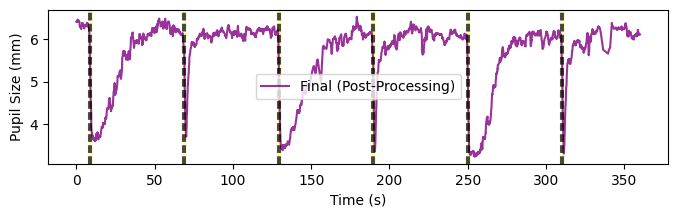

In [10]:
# Manual removal of last "surviving" blinks.
# We can see blinks at the following spots:
blink_locations = [
    (145, 165),  # Around 155s
    (330, 350),  # Around 345s
]
ps_final = ps_smoothed.copy()
for start, end in blink_locations:
    ps_final.limit_rate_of_change(0.1, start_time=start, end_time=end)
ps_final.drop_nan()
ps_final.interpolate(new_time=ps_final.get_time())

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ps_final.plot(ax=ax, label="Final (Post-Processing)", color="purple", alpha=0.8)
ps_final.plot_light_stimulus(
    ax=ax, color="yellow", alpha=0.3, label="_Light Stimuli"
)
ax.set_ylabel("Pupil Size (mm)")
ax.legend()
plt.show()